In [1]:
import numpy as np
from numpy import *
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import datetime
import netCDF4 as nc
import cftime
import cmocean as cmo
from netCDF4 import Dataset
import netCDF4
import matplotlib

### My attempt

In [7]:
casePath='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002/ocn/proc/tseries/month_1/'
caseName='b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002'

In [8]:
case = casePath + caseName + '.pop.h.' + 'TEMP.*' + '.nc' #sample one 0020-12.nc' 
data = xr.open_mfdataset(case)

In [9]:
data = data.TEMP[:,0,:,:]

In [16]:
data_nino3_4 = data.sel(data.TLAT=slice(5, -5), data.TLONG=slice(-170, -120)).mean('nlon').mean('nlat')

SyntaxError: keyword can't be an expression (<ipython-input-16-14b8c8bba831>, line 1)

In [12]:
data_nino3_4.TLAT.values

NameError: name 'data_nino3_4' is not defined

In [39]:
lon_min = -170 + 360
lon_max = -120 + 360
lat_min = -5
lat_max = 5
mask_lon = (data.TLONG >= lon_min) & (data.TLONG <= lon_max)
mask_lat = (data.TLAT >= lat_min) & (data.TLAT <= lat_max)
data_nino3_4 = data.where(mask_lon & mask_lat, drop=True)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [43]:
monthlydata_nino3_4 = data_nino3_4.sel(time=slice('1000-01-01 00:00:00','1030-12-31 00:00:00')).groupby('time.month').mean(dim='time')

In [44]:
data_nino3_4_anomalies = data_nino3_4.groupby('time.month') - monthlydata_nino3_4

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]


In [45]:
data_nino3_4_anomalies

<xarray.DataArray 'TEMP' (time: 12000, nlat: 38, nlon: 45)>
dask.array<getitem, shape=(12000, 38, 45), dtype=float32, chunksize=(1, 38, 45), chunktype=numpy.ndarray>
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(38, 45), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(38, 45), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(38, 45), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(38, 45), meta=np.ndarray>
  * time     (time) object 0850-02-01 00:00:00 ... 1850-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: nlat, nlon

In [46]:
from scipy.ndimage import uniform_filter1d

def rolling_mean(a, W, axis=-1):
    # a : Input ndarray
    # W : Window size
    # axis : Axis along which we will apply rolling/sliding mean
    hW = W//2
    L = a.shape[axis]-W+1   
    indexer = [slice(None) for _ in range(a.ndim)]
    indexer[axis] = slice(hW,hW+L)
    return uniform_filter1d(a,W,axis=axis)[tuple(indexer)]

def ENSO_area_mean(var):  
    # assumes 2D field as var input
    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])
    # loop over time
    for t in np.arange(var.shape[0]):
        ave[t] = np.ma.average(var[t,167:206,203:248])
    return ave

In [60]:
data_nino3_4_anomalies_mean = data_nino3_4_anomalies.mean(dim = 'nlat').mean(dim = 'nlon')

In [52]:
data_nino3_4_rm=rolling_mean(data_nino3_4_anomalies_mean,5,axis=0)

In [53]:
data_nino3_4_rm.shape

(11996,)

In [54]:
np.savetxt('data_nino3_4_rm.csv', data_nino3_4_rm, delimiter = ',')

In [2]:
data_nino3_4_rm = np.loadtxt('data_nino3_4_rm.csv', delimiter = ',')

In [3]:
data_nino3_4_rm

array([ 1.0314002 ,  0.18240935, -0.59487855, ...,  0.25113028,
        0.41801178,  0.53843951])

In [68]:
np.arange(850,950+1/12, 1/12)

array([850.        , 850.08333333, 850.16666667, ..., 949.91666667,
       950.        , 950.08333333])

In [70]:
np.arange(850,950+0.0001, 1/12).shape

(1201,)

In [71]:
data_nino3_4_rm[0:1198].shape

(1198,)

In [75]:
np.arange(850+2/12,949.99, 1/12).shape

(1198,)

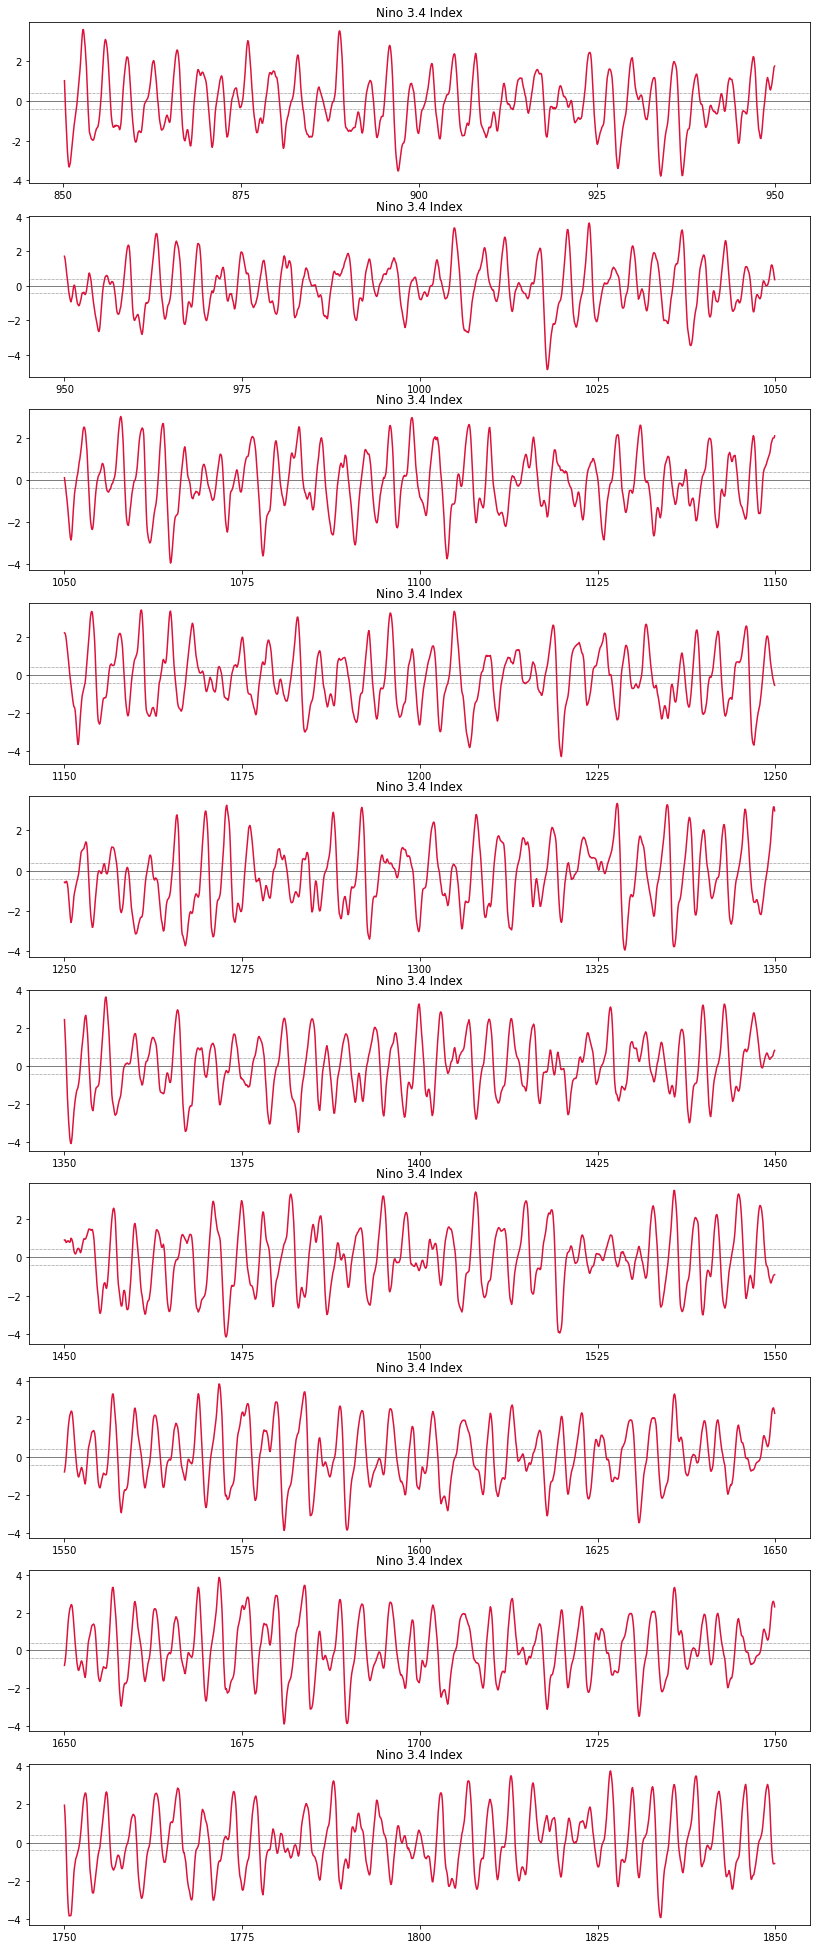

In [114]:
fig,ax=plt.subplots(10,1,figsize=(14,35))

plt.subplot(10,1,1)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
#plt.yticks([4.01, 2, 0, -2, -4])
#plt.gca().set_yticklabels(["4", "2", "0", "-2", "-4"])
plt.yticks([4, 2, 0, -2, -4], labels=["4", "2", "0", "-2", "-4"])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(850+2/12,949.99, 1/12), data_nino3_4_rm[0:1198],color='crimson')
plt.xticks([850, 875, 900, 925, 950], labels = ["850", "875", "900", "925", "950"])

plt.subplot(10,1,2)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(950,1049.99, 1/12), data_nino3_4_rm[1198:2398],color='crimson')
plt.xticks([950, 975, 1000, 1025, 1050], labels = ["950", "975", "1000", "1025", "1050"])

plt.subplot(10,1,3)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1050,1149.99, 1/12), data_nino3_4_rm[2398:3598],color='crimson')
plt.xticks([1050, 1075, 1100, 1125, 1150], labels = ["1050", "1075", "1100", "1125", "1150"])

plt.subplot(10,1,4)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1150,1249.99, 1/12), data_nino3_4_rm[3598:4798],color='crimson')
plt.xticks([1150, 1175, 1200, 1225, 1250], labels = ["1150", "1175", "1200", "1225", "1250"])

plt.subplot(10,1,5)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1250,1349.99, 1/12), data_nino3_4_rm[4798:5998],color='crimson')
plt.xticks([1250, 1275, 1300, 1325, 1350], labels = ["1250", "1275", "1300", "1325", "1350"])

plt.subplot(10,1,6)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1350,1449.99, 1/12), data_nino3_4_rm[5998:7198],color='crimson')
plt.xticks([1350, 1375, 1400, 1425, 1450], labels = ["1350", "1375", "1400", "1425", "1450"])

plt.subplot(10,1,7)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1450,1549.99, 1/12), data_nino3_4_rm[7198:8398],color='crimson')
plt.xticks([1450, 1475, 1500, 1525, 1550], labels = ["1450", "1475", "1500", "1525", "1550"])

plt.subplot(10,1,8)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1550,1649.99, 1/12), data_nino3_4_rm[8398:9598],color='crimson')
plt.xticks([1550, 1575, 1600, 1625, 1650], labels = ["1550", "1575", "1600", "1625", "1650"])

plt.subplot(10,1,9)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1650,1749.99, 1/12), data_nino3_4_rm[8398:9598],color='crimson')
plt.xticks([1650, 1675, 1700, 1725, 1750], labels = ["1650", "1675", "1700", "1725", "1750"])

plt.subplot(10,1,10)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.yticks([4, 2, 0, -2, -4])
plt.title('Nino 3.4 Index');
plt.plot(np.arange(1750,1849.99, 1/12), data_nino3_4_rm[9598:10798],color='crimson')
plt.xticks([1750, 1775, 1800, 1825, 1850], labels = ["1750", "1775", "1800", "1825", "1850"])

plt.show()

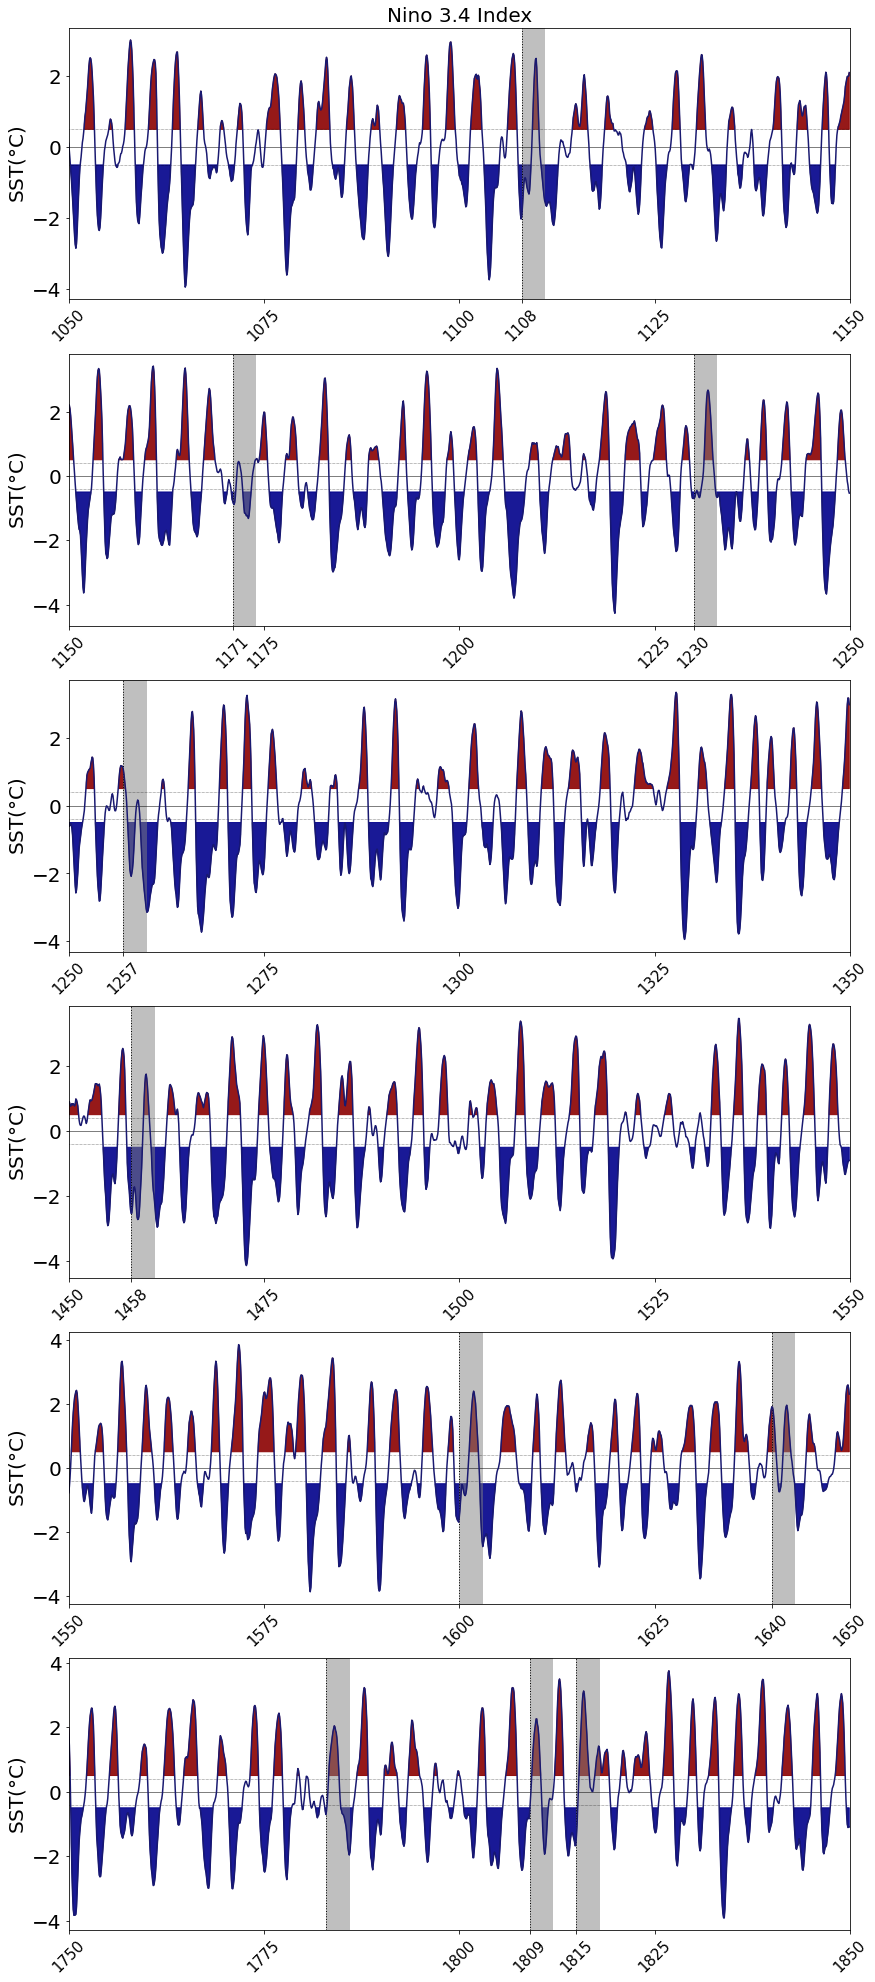

In [17]:
fig,ax=plt.subplots(6,1,figsize=(14,35))

#subplot 1
plt.subplot(6,1,1)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1108, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1108, 1111, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1050, 1149.99, 1/12), data_nino3_4_rm[2398:3598], 0.5, where= data_nino3_4_rm[2398:3598]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1050, 1149.99, 1/12), data_nino3_4_rm[2398:3598], -0.5, where= data_nino3_4_rm[2398:3598]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)", size=20)
plt.plot(np.arange(1050, 1149.99, 1/12), data_nino3_4_rm[2398:3598],color='midnightblue')
plt.xticks([1050, 1075, 1100, 1108, 1125, 1150], labels = ["1050", "1075", "1100", "1108", "1125", "1150"], rotation=45, size=15)
plt.xlim([1050,1150])

#Subplot 2
plt.subplot(6,1,2)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1171, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvline(1230, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1171, 1174, facecolor='grey', alpha=0.5)
plt.axvspan(1230, 1233, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1150,1249.99, 1/12), data_nino3_4_rm[3598:4798], 0.5, where= data_nino3_4_rm[3598:4798]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1150,1249.99, 1/12), data_nino3_4_rm[3598:4798], -0.5, where= data_nino3_4_rm[3598:4798]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
#plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)",size=20)
plt.plot(np.arange(1150,1249.99, 1/12), data_nino3_4_rm[3598:4798],color='midnightblue')
plt.xticks([1150, 1171, 1175, 1200, 1225, 1230, 1250], labels = ["1150","1171", "1175", "1200", "1225", "1230", "1250"], rotation=45, size=15)
plt.xlim([1150,1250])

#subplot 3
plt.subplot(6,1,3)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1257, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1257, 1260, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1250,1349.99, 1/12), data_nino3_4_rm[4798:5998], 0.5, where= data_nino3_4_rm[4798:5998]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1250,1349.99, 1/12), data_nino3_4_rm[4798:5998], -0.5, where= data_nino3_4_rm[4798:5998]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
#plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)",size=20)
plt.plot(np.arange(1250,1349.99, 1/12), data_nino3_4_rm[4798:5998],color='midnightblue')
plt.xticks([1250, 1257, 1275, 1300, 1325, 1350], labels = ["1250", "1257", "1275", "1300", "1325", "1350"], rotation=45, size=15)
plt.xlim([1250,1350])

#subplot 4
plt.subplot(6,1,4)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1458, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1458, 1461, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1450,1549.99, 1/12), data_nino3_4_rm[7198:8398], 0.5, where= data_nino3_4_rm[7198:8398]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1450,1549.99, 1/12), data_nino3_4_rm[7198:8398], -0.5, where= data_nino3_4_rm[7198:8398]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
#plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)",size=20)
plt.plot(np.arange(1450,1549.99, 1/12), data_nino3_4_rm[7198:8398],color='midnightblue')
plt.xticks([1450, 1458, 1475, 1500, 1525, 1550], labels = ["1450","1458", "1475", "1500", "1525", "1550"], rotation=45, size=15)
plt.xlim([1450,1550])

#Subplot 5
plt.subplot(6,1,5)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1600, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvline(1640, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1600, 1603, facecolor='grey', alpha=0.5)
plt.axvspan(1640, 1643, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1550,1649.99, 1/12), data_nino3_4_rm[8398:9598], 0.5, where= data_nino3_4_rm[8398:9598]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1550,1649.99, 1/12), data_nino3_4_rm[8398:9598], -0.5, where= data_nino3_4_rm[8398:9598]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
#plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)",size=20)
plt.plot(np.arange(1550,1649.99, 1/12), data_nino3_4_rm[8398:9598],color='midnightblue')
plt.xticks([1550, 1575, 1600, 1625, 1640, 1650], labels = ["1550", "1575", "1600", "1625", "1640", "1650"], rotation=45, size=15)
plt.xlim([1550,1650])

#Subplot 6
plt.subplot(6,1,6)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axhline(0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axhline(-0.4, color = 'black', linewidth = 0.5, linestyle = 'dotted')
plt.axvline(1783, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvline(1809, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvline(1815, color = 'black', linewidth = 1.0, linestyle = 'dotted')
plt.axvspan(1783, 1786, facecolor='grey', alpha=0.5)
plt.axvspan(1809, 1812, facecolor='grey', alpha=0.5)
plt.axvspan(1815, 1818, facecolor='grey', alpha=0.5)

plt.fill_between(np.arange(1750,1849.99, 1/12), data_nino3_4_rm[9598:10798], 0.5, where= data_nino3_4_rm[9598:10798]>=.5,
                 color = 'darkred', alpha = 0.9)

plt.fill_between(np.arange(1750,1849.99, 1/12), data_nino3_4_rm[9598:10798], -0.5, where= data_nino3_4_rm[9598:10798]<=-.5,
                 color = 'darkblue', alpha = 0.9)

plt.yticks([4, 2, 0, -2, -4], size=20)
#plt.title('Nino 3.4 Index', size=20);
plt.ylabel('SST'+ "($\degree$C)", size=20)
plt.plot(np.arange(1750,1849.99, 1/12), data_nino3_4_rm[9598:10798],color='midnightblue')
plt.xticks([1750, 1775, 1800, 1809, 1815, 1825, 1850], labels = ["1750", "1775", "1800", "1809", "1815", "1825", "1850"], rotation=45, size=15)
plt.xlim([1750,1850])

plt.show()